In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.append('script')
from script import dbconn
pgconn = dbconn.db_connection_psycopg()

In [3]:
# Fectching data from the postgreSql database and put the value on raw_df
raw_df = dbconn.db_read_table_psycopg(pgconn,'xdr_data')

c:\Users\o876\Desktop\User-Analytics-in-telecommunication-industry\script\dbconn.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql,pgconn)


# User Overview analysis

In [16]:
# Identifying the top 10 handsets used by the customers.
# Count handset usage
handset_counts = raw_df.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name='Count')

# Sort the results
sorted_handsets = handset_counts.sort_values(by='Count', ascending=False)

# Select the top 10 handsets
top_10_handsets = sorted_handsets.head(10)

# Print the top 10 handsets
print(top_10_handsets)

     Handset Manufacturer                  Handset Type  Count
317                Huawei              Huawei B528S-23A  19752
60                  Apple       Apple iPhone 6S (A1688)   9419
56                  Apple        Apple iPhone 6 (A1586)   9023
1396            undefined                     undefined   8987
66                  Apple        Apple iPhone 7 (A1778)   6326
80                  Apple       Apple iPhone Se (A1723)   5187
73                  Apple        Apple iPhone 8 (A1905)   4993
85                  Apple       Apple iPhone Xr (A2105)   4568
958               Samsung  Samsung Galaxy S8 (Sm-G950F)   4520
82                  Apple        Apple iPhone X (A1901)   3813


In [17]:
# Identifying Top 3 handset manufacturers
manufacturer_counts = raw_df['Handset Manufacturer'].value_counts().reset_index()
manufacturer_counts.columns = ['Handset Manufacturer', 'Count']

# Sort the results
sorted_manufacturers = manufacturer_counts.sort_values(by='Count', ascending=False)

# Select the top 3 handset manufacturers
top_3_manufacturers = sorted_manufacturers.head(3)

# Print the top 3 handset manufacturers
print(top_3_manufacturers)

  Handset Manufacturer  Count
0                Apple  60137
1              Samsung  40839
2               Huawei  34423


In [18]:
# Identify the top 5 handsets per top 3 handset manufacturer
# Count handset manufacturers and types
manufacturer_type_counts = raw_df.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name='Count')

# Sort the results within each manufacturer
sorted_manufacturer_types = manufacturer_type_counts.groupby('Handset Manufacturer').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True)

# Print the top 5 handsets per top 3 handset manufacturers
top_3_manufacturers = sorted_manufacturer_types['Handset Manufacturer'].unique()[:3]

for manufacturer in top_3_manufacturers:
    print(f"Top 5 handsets for {manufacturer}:")
    manufacturer_handsets = sorted_manufacturer_types[sorted_manufacturer_types['Handset Manufacturer'] == manufacturer]
    print(manufacturer_handsets)
    print()

Top 5 handsets for A-Link Telecom International Co Limited:
                      Handset Manufacturer                       Handset Type  \
0  A-Link Telecom International Co Limited   A-Link Telecom I. Cubot X18 Plus   
1  A-Link Telecom International Co Limited         A-Link Telecom I. Cubot A5   
2  A-Link Telecom International Co Limited  A-Link Telecom I. Cubot Note Plus   
3  A-Link Telecom International Co Limited     A-Link Telecom I. Cubot Note S   
4  A-Link Telecom International Co Limited       A-Link Telecom I. Cubot Nova   

   Count  
0      2  
1      1  
2      1  
3      1  
4      1  

Top 5 handsets for ASUSTeK:
  Handset Manufacturer                          Handset Type  Count
5              ASUSTeK       Asustek Asus Zb552Kl Zenfone Go      7
6              ASUSTeK   Asustek Asus Zenfone2 Laser Ze600Kl      5
7              ASUSTeK   Asustek Asus Zenfone2 Laser Ze601Kl      4
8              ASUSTeK  Asustek Asus Zenfone 2 Laser Ze500Kl      3
9              ASU

In [ ]:
# Identifying users’ behaviour on those Applications / Social Media, Google, Email, Youtube, Netflix, Gaming, Other.   

In [19]:
# Aggregate the number of xDR sessions per user
sessions_per_user = raw_df.groupby('MSISDN/Number')['Bearer Id'].count()
print(sessions_per_user)

MSISDN/Number
3.360100e+10       1
3.360100e+10       1
3.360100e+10       1
3.360101e+10       1
3.360101e+10       2
                ... 
3.379000e+10       1
3.379000e+10       1
4.188282e+10    1066
4.188282e+10       2
3.197021e+12       1
Name: Bearer Id, Length: 106856, dtype: int64


In [20]:
# Aggregate the session duration per user
session_duration_per_user = raw_df.groupby('MSISDN/Number')['Dur. (ms)'].sum()

# Display the result
print(session_duration_per_user)

MSISDN/Number
3.360100e+10    1.167200e+05
3.360100e+10    1.812300e+05
3.360100e+10    1.349690e+05
3.360101e+10    4.987800e+04
3.360101e+10    3.710400e+04
                    ...     
3.379000e+10    8.810000e+03
3.379000e+10    1.409880e+05
4.188282e+10    6.884746e+07
4.188282e+10    3.576386e+05
3.197021e+12    1.046086e+05
Name: Dur. (ms), Length: 106856, dtype: float64


In [21]:
# Aggregate the total download (Dl) and upload data per user
total_data_per_user = raw_df.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum()

# Display the result
print(total_data_per_user)

               Total DL (Bytes)  Total UL (Bytes)
MSISDN/Number                                    
3.360100e+10       8.426375e+08      3.605311e+07
3.360100e+10       1.207552e+08      3.610446e+07
3.360100e+10       5.566597e+08      3.930682e+07
3.360101e+10       4.019932e+08      2.032753e+07
3.360101e+10       1.363130e+09      9.428053e+07
...                         ...               ...
3.379000e+10       6.879252e+08      2.671643e+07
3.379000e+10       4.445751e+08      3.573224e+07
4.188282e+10       4.873783e+11      4.436642e+10
4.188282e+10       6.183326e+08      1.171089e+08
3.197021e+12       1.948281e+08      3.729592e+07

[106856 rows x 2 columns]


In [22]:
# Create a list of application columns
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Aggregate the total data volume per user and application
total_data_per_user_app = raw_df.groupby('MSISDN/Number')[[col + ' DL (Bytes)' for col in applications] + [col + ' UL (Bytes)' for col in applications]].sum()

# Display the result
print(total_data_per_user_app)

               Social Media DL (Bytes)  Google DL (Bytes)  Email DL (Bytes)  \
MSISDN/Number                                                                 
3.360100e+10              2.206504e+06       3.337123e+06      8.374000e+05   
3.360100e+10              2.598548e+06       4.197697e+06      2.828821e+06   
3.360100e+10              3.148004e+06       3.343483e+06      2.436500e+06   
3.360101e+10              2.514690e+05       5.937765e+06      2.178618e+06   
3.360101e+10              2.861230e+06       1.372867e+07      2.247808e+06   
...                                ...                ...               ...   
3.379000e+10              2.343200e+05       6.834178e+06      4.809460e+05   
3.379000e+10              4.422140e+05       1.472406e+06      2.513433e+06   
4.188282e+10              1.937715e+09       6.007942e+09      1.904048e+09   
4.188282e+10              1.996482e+06       1.420063e+07      5.508088e+06   
3.197021e+12              6.685960e+05       8.57277

In [ ]:
# Explanatory Data Analysis | EDA
# Treat all missing values and outliers in the dataset by replacing by the mean of the corresponding column.

In [4]:
raw_df.isna().sum()

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [23]:
#percent of missing data
def percent_missing(df):
    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    percentageMissing = (totalMissing / totalCells) * 100

    print("The dataset contains", round(percentageMissing, 2), "%", "missing values.")

percent_missing(raw_df)

C:\Users\o876\AppData\Local\Temp\ipykernel_6540\748560962.py:17: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  percent_missing(raw_df)


The dataset contains 0.0 % missing values.


In [24]:
# Replace missing values with column mean for numeric columns
numeric_columns = raw_df.select_dtypes(include=[np.number]).columns
raw_df[numeric_columns] = raw_df[numeric_columns].fillna(raw_df[numeric_columns].mean())

# Replace missing values with column mode for non-numeric columns
non_numeric_columns = raw_df.select_dtypes(exclude=[np.number]).columns
raw_df[non_numeric_columns] = raw_df[non_numeric_columns].fillna(raw_df[non_numeric_columns].mode().iloc[0])

# Identify and replace outliers with column mean for numeric columns
for col in numeric_columns:
    z_scores = (raw_df[col] - raw_df[col].mean()) / raw_df[col].std()
    outliers = (z_scores > 3) | (z_scores < -3)
    raw_df.loc[outliers, col] = raw_df[col].mean()

# Verify missing values and outliers have been treated
missing_values_after_treatment = raw_df.isnull().sum()
print("Missing Values After Treatment:\n", missing_values_after_treatment)

C:\Users\o876\AppData\Local\Temp\ipykernel_6540\4189417918.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9941733721775188' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  raw_df.loc[outliers, col] = raw_df[col].mean()
C:\Users\o876\AppData\Local\Temp\ipykernel_6540\4189417918.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.4975966826887821' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  raw_df.loc[outliers, col] = raw_df[col].mean()


Missing Values After Treatment:
 Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
1

In [25]:
raw_df.isna().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

In [26]:
#Solving The rest of missing values
def fix_missing_ffill(df, col):
    df[col] = df[col].fillna(method='ffill')
    return df[col]

raw_df['Start'] = fix_missing_ffill(raw_df, 'Start')
raw_df['End'] = fix_missing_ffill(raw_df, 'End')
raw_df['Last Location Name'] = fix_missing_ffill(raw_df, 'Last Location Name')

missing_values = raw_df.isna().sum()
print(missing_values)

C:\Users\o876\AppData\Local\Temp\ipykernel_6540\3212002553.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')


Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

In [27]:
# Analyze the basic metrics (mean, median, etc) from the dataset
raw_df.describe()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),Cluster,Engagement Score,Experience Score,Satisfaction Score,Engagement Cluster
count,1.500010e+05,150001.000000,150001.000000,150001.000000,1.500010e+05,1.500010e+05,1.500010e+05,150001.000000,150001.000000,150001.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,150001.000000,150001.000000,150001.000000,150001.000000,150001.000000
mean,1.013887e+19,499.188200,498.800880,95910.941496,2.082015e+14,3.373303e+10,4.847455e+13,72.367362,11.860518,10023.145920,...,8.288398e+06,4.211005e+08,8.264799e+06,4.112119e+07,4.546434e+08,0.994173,0.683607,0.710860,0.683607,0.497597
std,2.883600e+18,288.610872,288.096693,54634.923967,4.481712e+08,6.916051e+08,2.237359e+13,56.681466,11.599847,16441.694938,...,4.782700e+06,2.432050e+08,4.769004e+06,1.125601e+07,2.441421e+08,0.790666,0.128600,0.129478,0.128600,0.499996
min,6.917538e+18,0.000000,0.000000,7142.000000,2.082001e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,0.000000,...,5.900000e+01,3.290000e+03,1.480000e+02,7.377304e+06,7.114041e+06,0.000000,0.291212,0.315024,0.291212,0.000000
25%,7.349883e+18,250.000000,251.000000,57442.000000,2.082014e+14,3.365151e+10,3.546261e+13,35.000000,3.000000,43.000000,...,4.128476e+06,2.101869e+08,4.145943e+06,3.322877e+07,2.431072e+08,0.000000,0.598517,0.625251,0.598517,0.000000
50%,7.349883e+18,499.000000,500.000000,86399.000000,2.082015e+14,3.366380e+10,3.572241e+13,54.000000,7.000000,63.000000,...,8.291208e+06,4.218030e+08,8.267071e+06,4.113671e+07,4.558409e+08,1.000000,0.688674,0.715853,0.688674,0.000000
75%,1.304243e+19,749.000000,750.000000,123823.000000,2.082018e+14,3.368473e+10,8.611970e+13,109.795706,17.662883,13963.000000,...,1.243162e+07,6.316918e+08,1.238415e+07,4.902660e+07,6.657051e+08,2.000000,0.774042,0.802385,0.774042,1.000000
max,1.318654e+19,999.000000,999.000000,278803.000000,2.082022e+14,4.188282e+10,9.900120e+13,453.000000,71.000000,67861.000000,...,1.655879e+07,8.434425e+08,1.655882e+07,7.483343e+07,9.029696e+08,2.000000,1.073769,1.103452,1.073769,1.000000


In [29]:
# Conduct a Non-Graphical Univariate Analysis by computing dispersion parameters for each quantitative variable.

quantitative_variables = []

# Iterate over each column in the dataset to find the quantitative variable
for column in raw_df.columns:   
    if raw_df[column].dtype in [int, float]:
        quantitative_variables.append(column)

# Solution: By calculating the range or Difference b/n max and min value in each variable
for column_name in quantitative_variables:
    column_data = raw_df[column_name]
    data_range = column_data.max() - column_data.min()
    print("Range of", column_name, ":", data_range)

Range of Bearer Id : 6.26900364859067e+18
Range of Start ms : 999.0
Range of End ms : 999.0
Range of Dur. (ms) : 271661.0
Range of IMSI : 2100641934.0
Range of MSISDN/Number : 8281817823.027367
Range of IMEI : 98561186125774.0
Range of Avg RTT DL (ms) : 453.0
Range of Avg RTT UL (ms) : 71.0
Range of Avg Bearer TP DL (kbps) : 67861.0
Range of Avg Bearer TP UL (kbps) : 8515.0
Range of TCP DL Retrans. Vol (Bytes) : 67346368.0
Range of TCP UL Retrans. Vol (Bytes) : 3629258.0
Range of DL TP < 50 Kbps (%) : 36.0
Range of 50 Kbps < DL TP < 250 Kbps (%) : 15.0
Range of 250 Kbps < DL TP < 1 Mbps (%) : 9.0
Range of DL TP > 1 Mbps (%) : 8.0
Range of UL TP < 10 Kbps (%) : 6.0
Range of 10 Kbps < UL TP < 50 Kbps (%) : 4.0
Range of 50 Kbps < UL TP < 300 Kbps (%) : 1.0
Range of UL TP > 300 Kbps (%) : 0.07892285317909778
Range of HTTP DL (Bytes) : 498114325.0
Range of HTTP UL (Bytes) : 12833778.0
Range of Activity Duration DL (ms) : 9466816.0
Range of Activity Duration UL (ms) : 7294021.0
Range of Dur.

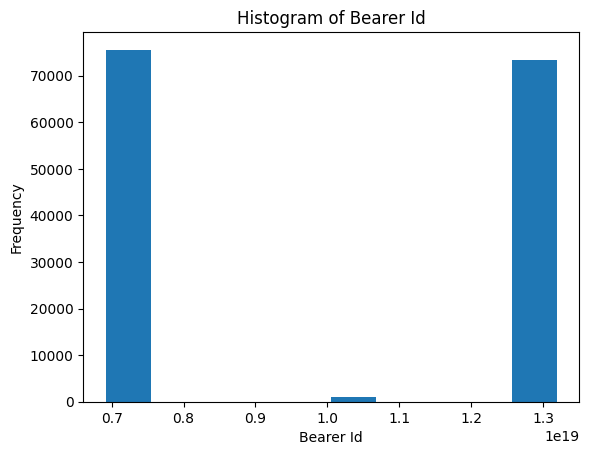

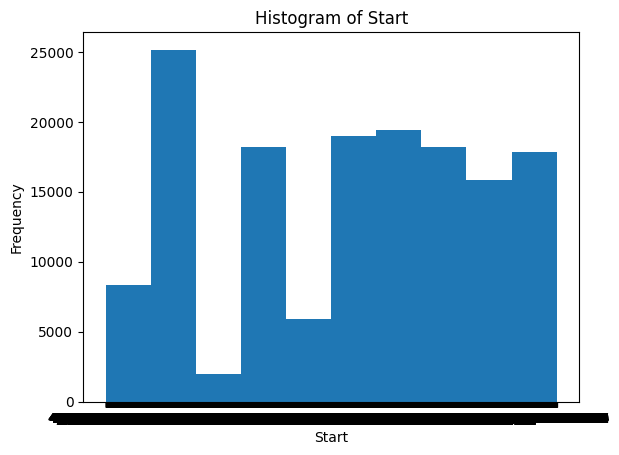

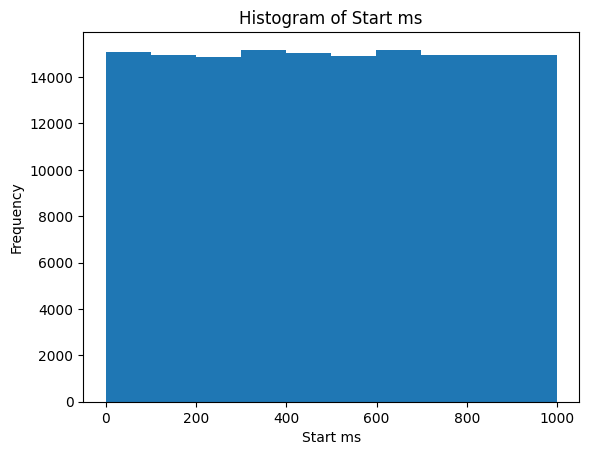

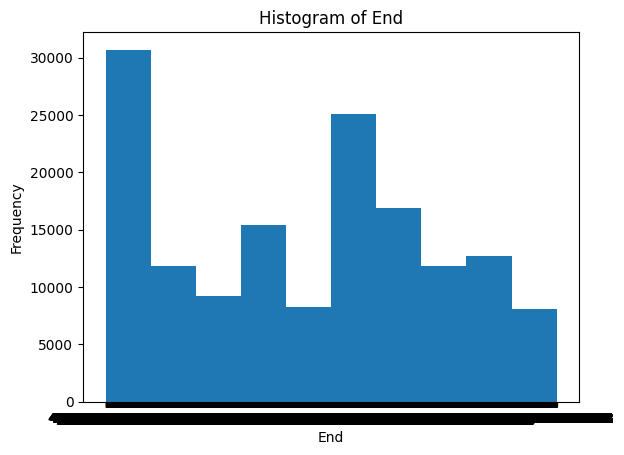

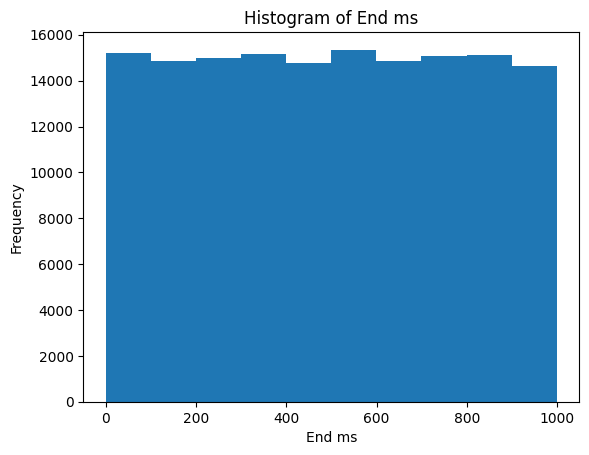

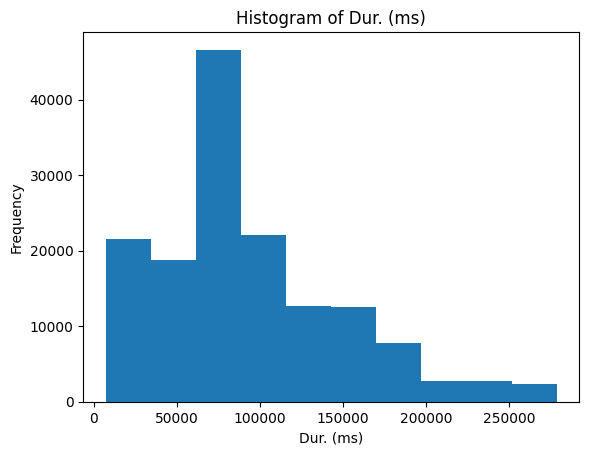

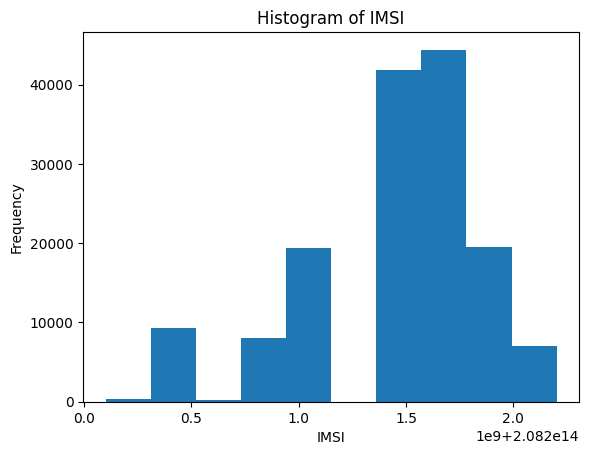

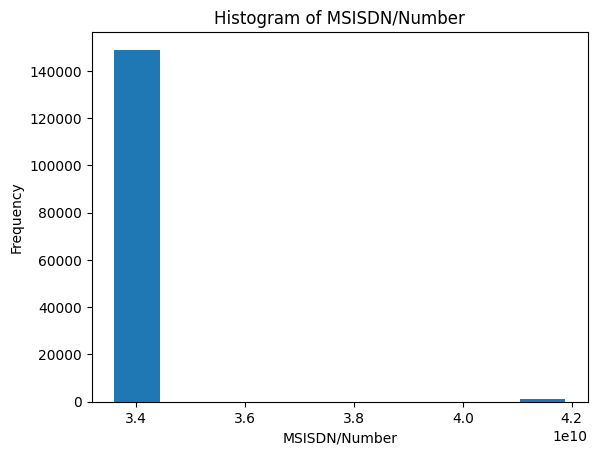

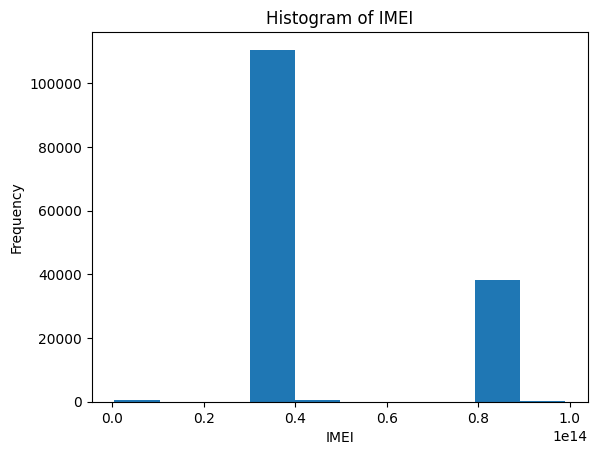

KeyboardInterrupt: 

In [30]:
# Conduct a Graphical Univariate Analysis by identifying the most suitable plotting options for each variable and interpret your findings.
# column_name = 'Avg RTT DL (ms)'
clean_Data = raw_df.dropna()
column_names = clean_Data.columns

for column_name in column_names:
    column_data = clean_Data[column_name]    
    plt.hist(column_data, bins=10)
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + column_name)
    plt.show()

In [ ]:
# Variable transformations
# Segment the users into top five decile classes based on the total duration for all sessions and compute the total data (DL+UL) per decile class. 

# Calculate the total duration for all sessions for each user
user_total_duration = raw_df.groupby('MSISDN/Number')['Dur. (ms)'].sum()

# Segment users into decile classes
user_deciles = pd.qcut(user_total_duration, q=10, labels=False, duplicates='drop')

# Compute the total data (DL+UL) per decile class
data_per_decile = raw_df.groupby(user_deciles)[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().reset_index()

In [ ]:
# Correlation Analysis – compute a correlation matrix for the following variables and interpret your findings: Social Media data, Google data, Email data, Youtube data, Netflix data, Gaming data, Other data 
# Select the columns for correlation analysis
columns = [
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]

# Create a subset dataframe with the selected columns
subset_df = raw_df[columns]

# Compute the correlation matrix
correlation_matrix = subset_df.corr()

# Display the correlation matrix
print(correlation_matrix)

#  User Engagement analysis

In [31]:
# Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric

# Aggregate metrics per customer
aggregated_data = raw_df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'nunique',  # Session frequency
    'Dur. (ms)': 'sum',  # Session duration
    'Total UL (Bytes)': 'sum',  # Upload traffic
    'Total DL (Bytes)': 'sum'  # Download traffic
}).reset_index()

# Rename the columns for better readability
aggregated_data.rename(columns={
    'Bearer Id': 'Session Frequency',
    'Dur. (ms)': 'Session Duration',
    'Total UL (Bytes)': 'Total Upload Traffic',
    'Total DL (Bytes)': 'Total Download Traffic'
}, inplace=True)

# Report the top 10 customers per engagement metric
top_10_frequency = aggregated_data.nlargest(10, 'Session Frequency')
top_10_duration = aggregated_data.nlargest(10, 'Session Duration')
top_10_upload_traffic = aggregated_data.nlargest(10, 'Total Upload Traffic')
top_10_download_traffic = aggregated_data.nlargest(10, 'Total Download Traffic')

# Display the results
print("Top 10 customers by Session Frequency:")
print(top_10_frequency)

print("\nTop 10 customers by Session Duration:")
print(top_10_duration)

print("\nTop 10 customers by Total Upload Traffic:")
print(top_10_upload_traffic)

print("\nTop 10 customers by Total Download Traffic:")
print(top_10_download_traffic)

Top 10 customers by Session Frequency:
        MSISDN/Number  Session Frequency  Session Duration  \
106854   4.188282e+10                502      6.665088e+07   
13526    3.362632e+10                 18      2.344694e+06   
6437     3.361489e+10                 17      2.257130e+06   
13180    3.362578e+10                 17      1.884503e+06   
37052    3.365973e+10                 16      2.990053e+06   
76363    3.367588e+10                 15      2.227144e+06   
92924    3.376054e+10                 15      1.839585e+06   
65118    3.366716e+10                 13      1.577025e+06   
666      3.360313e+10                 12      1.298237e+06   
1279     3.360452e+10                 12      1.680721e+06   

        Total Upload Traffic  Total Download Traffic  
106854          4.436642e+10            4.873783e+11  
13526           6.696507e+08            7.301517e+09  
6437            6.894830e+08            8.156743e+09  
13180           7.295774e+08            7.770043e+09  
370

In [32]:
# Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 
# Aggregate metrics per customer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

aggregated_data = raw_df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'nunique',  # Session frequency
    'Dur. (ms)': 'sum',  # Session duration
    'Total UL (Bytes)': 'sum',  # Upload traffic
    'Total DL (Bytes)': 'sum'  # Download traffic
}).reset_index()

# Normalize the engagement metrics
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(aggregated_data.iloc[:, 1:])  # Exclude customer ID

# Run k-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(normalized_data)

# Add the cluster labels to the aggregated data
aggregated_data['Cluster'] = kmeans.labels_

# Report the top customers per cluster
top_customers_per_cluster = []
for i in range(k):
    cluster_customers = aggregated_data[aggregated_data['Cluster'] == i].nlargest(10, 'Bearer Id')
    top_customers_per_cluster.append(cluster_customers)

# Display the results
for i, cluster_customers in enumerate(top_customers_per_cluster):
    print(f"\nTop 10 customers in Cluster {i+1}:")
    print(cluster_customers)

c:\Users\o876\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Top 10 customers in Cluster 1:
       MSISDN/Number  Bearer Id  Dur. (ms)  Total UL (Bytes)  \
457     3.360227e+10          3    50982.0        96844058.0   
1354    3.360515e+10          3    68251.0       101017231.0   
3250    3.360987e+10          3    95085.0       105490927.0   
10572   3.362155e+10          3    42678.0       141201804.0   
12059   3.362396e+10          3    83181.0        83706591.0   
12473   3.362462e+10          3    56433.0       141137590.0   
18178   3.363547e+10          3    96270.0        94908806.0   
23180   3.365006e+10          3    92861.0       139594344.0   
24866   3.365046e+10          3    70017.0       104090483.0   
33088   3.365887e+10          3    41089.0       125610002.0   

       Total DL (Bytes)  Cluster  
457        1.333235e+09        0  
1354       1.460710e+09        0  
3250       8.365219e+08        0  
10572      1.210225e+09        0  
12059      9.833107e+08        0  
12473      7.178695e+08        0  
18178      8.16246

In [33]:
# Compute the minimum, maximum, average & total non-normalized metrics for each cluster. 
# Interpret your results visually with accompanying text explaining your findings.

# Aggregate metrics per customer
aggregated_data = raw_df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'nunique',  # Session frequency
    'Dur. (ms)': 'sum',  # Session duration
    'Total UL (Bytes)': 'sum',  # Upload traffic
    'Total DL (Bytes)': 'sum'  # Download traffic
}).reset_index()

# Normalize the engagement metrics
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(aggregated_data.iloc[:, 1:])  # Exclude customer ID

# Run k-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(normalized_data)

# Add the cluster labels to the aggregated data
aggregated_data['Cluster'] = kmeans.labels_

# Compute non-normalized metrics for each cluster
cluster_metrics = aggregated_data.groupby('Cluster').agg({
    'Bearer Id': ['min', 'max', 'mean', 'sum'],  # Session frequency
    'Dur. (ms)': ['min', 'max', 'mean', 'sum'],  # Session duration
    'Total UL (Bytes)': ['min', 'max', 'mean', 'sum'],  # Upload traffic
    'Total DL (Bytes)': ['min', 'max', 'mean', 'sum']  # Download traffic
})

# Display the results
print("Non-normalized metrics for each cluster:")
print(cluster_metrics)

c:\Users\o876\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Non-normalized metrics for each cluster:
        Bearer Id                              Dur. (ms)                \
              min  max        mean     sum           min           max   
Cluster                                                                  
0               1    3    1.175647  111315  7.142000e+03  3.848630e+05   
1             502  502  502.000000     502  6.665088e+07  6.665088e+07   
2               1   18    2.969436   36141  4.689600e+04  2.990053e+06   

                                    Total UL (Bytes)                \
                 mean           sum              min           max   
Cluster                                                              
0        1.050280e+05  9.944474e+09     7.408995e+06  2.342026e+08   
1        6.665088e+07  6.665088e+07     4.436642e+10  4.436642e+10   
2        3.595113e+05  4.375612e+09     2.589789e+07  7.295774e+08   

                                    Total DL (Bytes)                \
                 mean  

In [34]:
# Aggregate user total traffic per application and derive the top 10 most engaged users per application

# Extract the relevant columns for application traffic
app_columns = ['MSISDN/Number', 'Social Media DL (Bytes)', 'Google DL (Bytes)', 
               'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 
               'Gaming DL (Bytes)', 'Other DL (Bytes)']
app_traffic = raw_df[app_columns].copy()

# Rename the application columns for easier processing
app_traffic.columns = ['MSISDN/Number', 'Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Melt the dataframe to combine all application columns into a single 'Application' column
app_traffic = app_traffic.melt(id_vars='MSISDN/Number', var_name='Application', value_name='Total Traffic')

# Aggregate total traffic per application for each user
app_traffic = app_traffic.groupby(['MSISDN/Number', 'Application'])['Total Traffic'].sum().reset_index()

# Derive the top 10 most engaged users per application
top_users_per_app = []
unique_apps = app_traffic['Application'].unique()

for app in unique_apps:
    top_users = app_traffic[app_traffic['Application'] == app].nlargest(10, 'Total Traffic')
    top_users_per_app.append(top_users)

# Display the results
for i, app in enumerate(unique_apps):
    print(f"\nTop 10 most engaged users for Application '{app}':")
    print(top_users_per_app[i])


Top 10 most engaged users for Application 'Email':
        MSISDN/Number Application  Total Traffic
747978   4.188282e+10       Email   1.904048e+09
45059    3.361489e+10       Email   3.360721e+07
94682    3.362632e+10       Email   3.340478e+07
92260    3.362578e+10       Email   3.189541e+07
742966   3.378632e+10       Email   3.087691e+07
259364   3.365973e+10       Email   2.990765e+07
650468   3.376054e+10       Email   2.643790e+07
420609   3.366546e+10       Email   2.594287e+07
534541   3.367588e+10       Email   2.428472e+07
605185   3.369879e+10       Email   2.416560e+07

Top 10 most engaged users for Application 'Gaming':
        MSISDN/Number Application  Total Traffic
747979   4.188282e+10      Gaming   4.527450e+11
45060    3.361489e+10      Gaming   7.622035e+09
650469   3.376054e+10      Gaming   7.316364e+09
92261    3.362578e+10      Gaming   7.171884e+09
534542   3.367588e+10      Gaming   6.863307e+09
94683    3.362632e+10      Gaming   6.745734e+09
259365   3.36

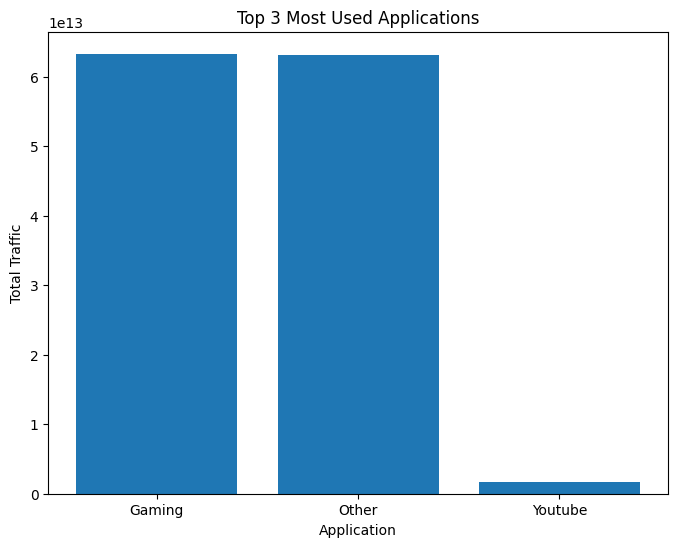

In [35]:
# Plot the top 3 most used applications using appropriate charts. 

# Extract the relevant columns for application traffic
app_columns = ['MSISDN/Number', 'Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']
app_traffic = raw_df[app_columns].copy()

# Rename the application columns for easier processing
app_traffic.columns = ['MSISDN/Number', 'Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Melt the dataframe to combine all application columns into a single 'Application' column
app_traffic = app_traffic.melt(id_vars='MSISDN/Number', var_name='Application', value_name='Total Traffic')

# Aggregate total traffic per application
app_traffic = app_traffic.groupby('Application')['Total Traffic'].sum().reset_index()

# Sort applications by total traffic in descending order
app_traffic = app_traffic.sort_values('Total Traffic', ascending=False)

# Select the top 3 most used applications
top_3_apps = app_traffic.head(3)

# Plot the top 3 most used applications
plt.figure(figsize=(8, 6))
plt.bar(top_3_apps['Application'], top_3_apps['Total Traffic'])
plt.xlabel('Application')
plt.ylabel('Total Traffic')
plt.title('Top 3 Most Used Applications')
plt.show()

In [ ]:
# Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: 
# What is the optimized value of k (use elbow method for this)?

# Experience Analytics

In [36]:
# Aggregate average TCP retransmission per customer
average_tcp_retransmission = raw_df.groupby('MSISDN/Number')['TCP DL Retrans. Vol (Bytes)'].mean()

# Print the aggregated results
print("Average TCP Retransmission per Customer:")
print(average_tcp_retransmission)

Average TCP Retransmission per Customer:
MSISDN/Number
3.360100e+10    2.080991e+07
3.360100e+10    2.080991e+07
3.360100e+10    2.080991e+07
3.360101e+10    1.066000e+03
3.360101e+10    1.507977e+07
                    ...     
3.378998e+10    1.040503e+07
3.379000e+10    2.150440e+05
3.379000e+10    2.080991e+07
4.188282e+10    8.752550e+06
4.188282e+10    2.080991e+07
Name: TCP DL Retrans. Vol (Bytes), Length: 106856, dtype: float64


In [37]:
# Aggregate average RTT per customer
average_rtt = raw_df.groupby('MSISDN/Number')['Avg RTT DL (ms)'].mean()

# Print the aggregated results
print("Average RTT per Customer:")
print(average_rtt)

Average RTT per Customer:
MSISDN/Number
3.360100e+10     46.000000
3.360100e+10     30.000000
3.360100e+10    109.795706
3.360101e+10     69.000000
3.360101e+10     57.000000
                   ...    
3.378998e+10     83.897853
3.379000e+10     42.000000
3.379000e+10     34.000000
4.188282e+10     99.036060
4.188282e+10    109.795706
Name: Avg RTT DL (ms), Length: 106856, dtype: float64


In [38]:
# Aggregate handset type per customer
handset_type = raw_df.groupby('MSISDN/Number')['Handset Type'].first()

# Print the aggregated results
print("Aggregate handset type per Customer:")
print(handset_type)

Aggregate handset type per Customer:
MSISDN/Number
3.360100e+10      Huawei P20 Lite Huawei Nova 3E
3.360100e+10              Apple iPhone 7 (A1778)
3.360100e+10                           undefined
3.360101e+10             Apple iPhone 5S (A1457)
3.360101e+10             Apple iPhone Se (A1723)
                              ...               
3.378998e+10                           undefined
3.379000e+10                 Huawei Honor 9 Lite
3.379000e+10         Apple iPhone 8 Plus (A1897)
4.188282e+10                    Huawei B528S-23A
4.188282e+10    Quectel Wireless. Quectel Ec21-E
Name: Handset Type, Length: 106856, dtype: object


In [39]:
# Aggregate average throughput per customer
average_throughput = raw_df.groupby('MSISDN/Number')['Avg Bearer TP DL (kbps)'].mean()

# Print the aggregated results
print("Average Throughput per Customer:")
print(average_throughput)

Average Throughput per Customer:
MSISDN/Number
3.360100e+10       37.000000
3.360100e+10       48.000000
3.360100e+10       48.000000
3.360101e+10      204.000000
3.360101e+10    20197.500000
                    ...     
3.378998e+10     6671.022963
3.379000e+10     9978.000000
3.379000e+10       68.000000
4.188282e+10    12201.366912
4.188282e+10        6.500000
Name: Avg Bearer TP DL (kbps), Length: 106856, dtype: float64


In [ ]:
# Compute & list 10 of the top, bottom and most frequent:

In [40]:
# Get the top 10 TCP values
top_tcp_values = raw_df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)

# Get the bottom 10 TCP values
bottom_tcp_values = raw_df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)

# Get the most frequent TCP values
most_frequent_tcp_values = raw_df['TCP DL Retrans. Vol (Bytes)'].value_counts().head(10)

# Print the results
print("Top 10 TCP Values:")
print(top_tcp_values)
print("\nBottom 10 TCP Values:")
print(bottom_tcp_values)
print("\nMost Frequent TCP Values:")
print(most_frequent_tcp_values)

Top 10 TCP Values:
121311    67346370.0
40515     67339461.0
66800     67332334.0
117582    67089300.0
116080    67067323.0
39829     66987733.0
59140     66972431.0
38808     66948056.0
41099     66889160.0
68199     66831296.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Bottom 10 TCP Values:
59717     2.0
125094    2.0
2850      4.0
39610     4.0
52488     4.0
60376     4.0
60426     4.0
75093     4.0
100314    4.0
143429    4.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Most Frequent TCP Values:
TCP DL Retrans. Vol (Bytes)
2.080991e+07    88146
1.522457e+07     1404
2.080991e+07      538
1.330000e+03      433
2.660000e+03      219
3.800000e+01      200
9.200000e+01      192
1.318000e+03      156
5.430000e+02      133
3.990000e+03      114
Name: count, dtype: int64


In [41]:
# Get the top 10 RTT values
top_rtt_values = raw_df['Avg RTT DL (ms)'].nlargest(10)

# Get the bottom 10 RTT values
bottom_rtt_values = raw_df['Avg RTT DL (ms)'].nsmallest(10)

# Get the most frequent RTT values
most_frequent_rtt_values = raw_df['Avg RTT DL (ms)'].value_counts().head(10)

# Print the results
print("Top 10 RTT Values:")
print(top_rtt_values)
print("\nBottom 10 RTT Values:")
print(bottom_rtt_values)
print("\nMost Frequent RTT Values:")
print(most_frequent_rtt_values)

Top 10 RTT Values:
1902      453.0
8987      453.0
15695     453.0
19693     453.0
26453     453.0
35050     453.0
44117     453.0
58718     453.0
141314    453.0
1154      452.0
Name: Avg RTT DL (ms), dtype: float64

Bottom 10 RTT Values:
42612     0.0
52225     0.0
60152     0.0
61152     0.0
61345     0.0
103328    0.0
124544    0.0
142526    0.0
143878    0.0
71739     2.0
Name: Avg RTT DL (ms), dtype: float64

Most Frequent RTT Values:
Avg RTT DL (ms)
109.795706    27829
28.000000      3553
27.000000      3380
34.000000      3296
35.000000      2892
37.000000      2718
36.000000      2645
85.256566      2590
38.000000      2547
29.000000      2498
Name: count, dtype: int64


In [42]:
# Get the top 10 throughput values
top_throughput_values = raw_df['Avg Bearer TP DL (kbps)'].nlargest(10)

# Get the bottom 10 throughput values
bottom_throughput_values = raw_df['Avg Bearer TP DL (kbps)'].nsmallest(10)

# Get the most frequent throughput values
most_frequent_throughput_values = raw_df['Avg Bearer TP DL (kbps)'].value_counts().head(10)

# Print the results
print("Top 10 Throughput Values:")
print(top_throughput_values)
print("\nBottom 10 Throughput Values:")
print(bottom_throughput_values)
print("\nMost Frequent Throughput Values:")
print(most_frequent_throughput_values)

Top 10 Throughput Values:
584       67861.0
6824      67861.0
2208      67859.0
32898     67854.0
119922    67854.0
83391     67850.0
65752     67846.0
87282     67840.0
16425     67834.0
120310    67834.0
Name: Avg Bearer TP DL (kbps), dtype: float64

Bottom 10 Throughput Values:
13      0.0
149     0.0
364     0.0
546     0.0
618     0.0
679     0.0
756     0.0
809     0.0
893     0.0
1185    0.0
Name: Avg Bearer TP DL (kbps), dtype: float64

Most Frequent Throughput Values:
Avg Bearer TP DL (kbps)
23.000000       7324
43.000000       4352
44.000000       4186
6.000000        3983
11315.319458    3021
13300.045927    2984
22.000000       2867
48.000000       2778
63.000000       2757
42.000000       2689
Name: count, dtype: int64


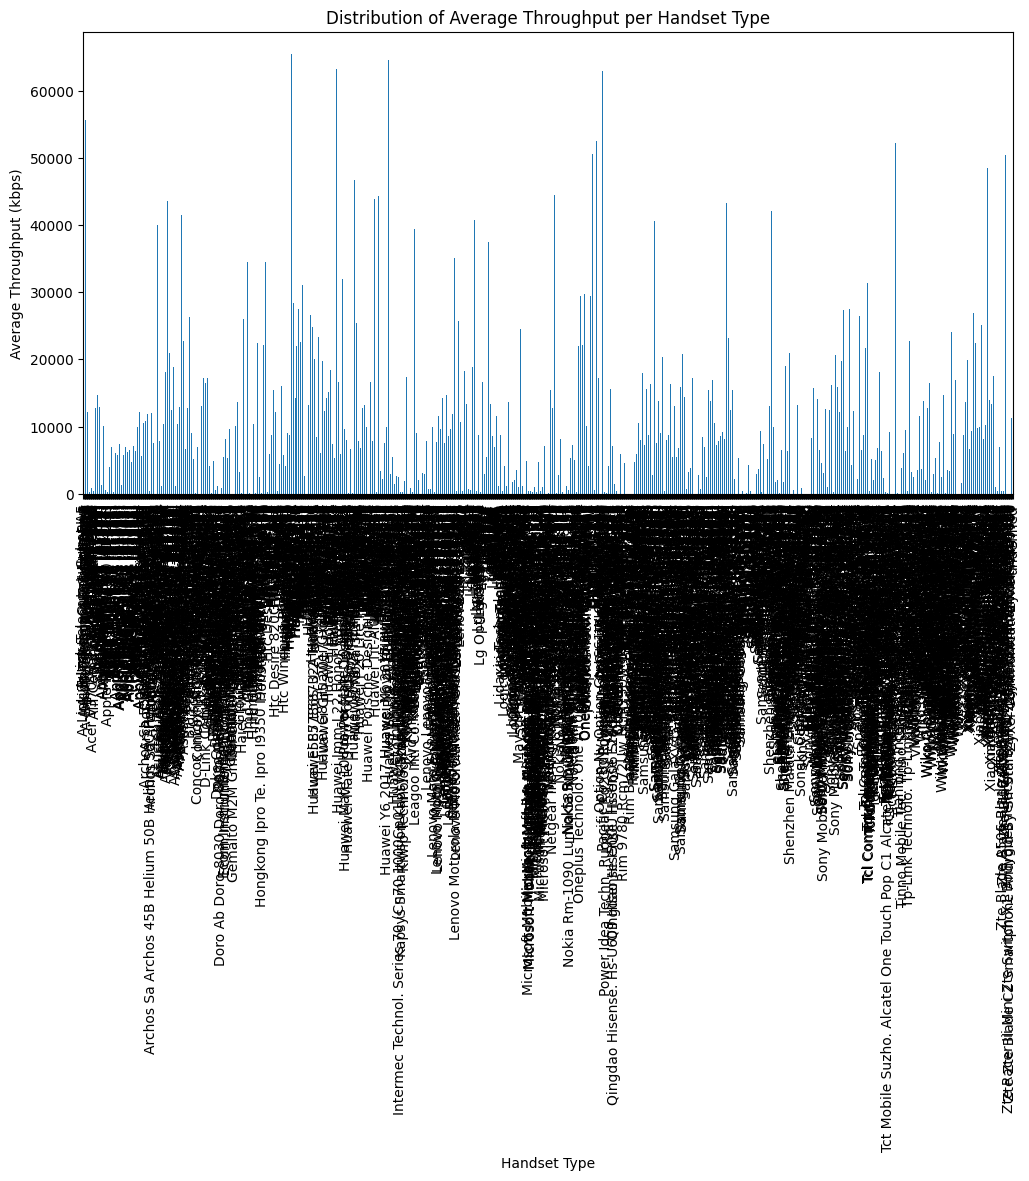

In [43]:
# Compute the distribution of average throughput per handset type
avg_throughput_distribution = raw_df.groupby('Handset Type')['Avg Bearer TP DL (kbps)'].mean()

# Plot the distribution
plt.figure(figsize=(12, 6))
avg_throughput_distribution.plot(kind='bar')
plt.xlabel('Handset Type')
plt.ylabel('Average Throughput (kbps)')
plt.title('Distribution of Average Throughput per Handset Type')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Compute the average TCP retransmission view per handset type
avg_tcp_retransmission = raw_df.groupby('Handset Type')['TCP DL Retrans. Vol (Bytes)'].mean()

# Plot the average TCP retransmission view per handset type
plt.figure(figsize=(12, 6))
avg_tcp_retransmission.plot(kind='bar')
plt.xlabel('Handset Type')
plt.ylabel('Average TCP Retransmission')
plt.title('Average TCP Retransmission View per Handset Type')
plt.xticks(rotation=90)
plt.show()

In [44]:
from sklearn.cluster import KMeans

# Select the relevant columns for clustering
data = raw_df[['Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)']]

# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data)

# Add cluster labels to the dataset
raw_df['Cluster'] = kmeans.labels_

# Describe each cluster
cluster_descriptions = raw_df.groupby('Cluster').agg({
    'Avg RTT DL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'TCP DL Retrans. Vol (Bytes)': 'mean'
})

# Print the cluster descriptions
print("Cluster Descriptions:")
print(cluster_descriptions)

c:\Users\o876\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Descriptions:
         Avg RTT DL (ms)  Avg Bearer TP DL (kbps)  TCP DL Retrans. Vol (Bytes)
Cluster                                                                       
0              67.419598              2532.315357                 2.065486e+07
1              79.891237             22678.227468                 1.464729e+06
2             115.620465             29151.454856                 4.793582e+07


# Satisfaction Analysis

In [8]:
# Engagement score to each user. Consider the engagement score as the Euclidean distance between the user data point & 
# the less engaged cluster (use the first clustering for this) (Euclidean Distance)

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

engagement_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']
engagement_data = raw_df[engagement_columns]

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(MinMaxScaler().fit_transform(engagement_data))
raw_df['Cluster'] = kmeans.predict(MinMaxScaler().fit_transform(engagement_data))

# Compute engagement scores
raw_df['Engagement Score'] = kmeans.transform(MinMaxScaler().fit_transform(engagement_data)).min(axis=1)

# Display the top 10 users with the lowest engagement scores
top_10_least_engaged_users = raw_df.nsmallest(10, 'Engagement Score')
print("Top 10 least engaged users:")
print(top_10_least_engaged_users[['MSISDN/Number', 'Cluster', 'Engagement Score']])

c:\Users\o876\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Top 10 least engaged users:
        MSISDN/Number  Cluster  Engagement Score
16009    3.360985e+10        1          0.068658
148295   3.369948e+10        2          0.144754
117786   3.366856e+10        2          0.156107
71508    3.366376e+10        0          0.161020
115538   3.365013e+10        0          0.161214
35951    3.366480e+10        1          0.164404
34585    3.366612e+10        1          0.164657
127173   3.366355e+10        2          0.168642
71466    3.376233e+10        2          0.168886
34146    3.366444e+10        1          0.169006


In [10]:
# Experience score to each user. Consider the experience score as the Euclidean distance between the user data point & the worst experience’s cluster. 

engagement_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']
engagement_data = raw_df[engagement_columns]

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(MinMaxScaler().fit_transform(engagement_data))
raw_df['Cluster'] = kmeans.predict(MinMaxScaler().fit_transform(engagement_data))

# Compute the worst experience cluster
worst_experience_cluster = np.argmin(kmeans.inertia_)
worst_experience_cluster_centroid = kmeans.cluster_centers_[worst_experience_cluster]

# Compute experience scores
raw_df['Experience Score'] = kmeans.transform(MinMaxScaler().fit_transform(engagement_data)).min(axis=1)

# Display the top 10 users with the worst experience scores
top_10_worst_experience_users = raw_df.nsmallest(10, 'Experience Score')
print("Top 10 users with the worst experience:")
print(top_10_worst_experience_users[['MSISDN/Number', 'Cluster', 'Experience Score']])

c:\Users\o876\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Top 10 users with the worst experience:
        MSISDN/Number  Cluster  Experience Score
16009    3.360985e+10        1          0.068658
148295   3.369948e+10        2          0.144754
117786   3.366856e+10        2          0.156107
71508    3.366376e+10        0          0.161020
115538   3.365013e+10        0          0.161214
35951    3.366480e+10        1          0.164404
34585    3.366612e+10        1          0.164657
127173   3.366355e+10        2          0.168642
71466    3.376233e+10        2          0.168886
34146    3.366444e+10        1          0.169006


In [11]:
# Consider the average of both engagement & experience scores as  the satisfaction score & report the top 10 satisfied customer

# Calculate engagement scores
engagement_data = raw_df[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']]
engagement_scores = KMeans(n_clusters=3, random_state=42).fit_transform(MinMaxScaler().fit_transform(engagement_data)).min(axis=1)

# Calculate experience scores
experience_scores = KMeans(n_clusters=3, random_state=42).fit_transform(MinMaxScaler().fit_transform(engagement_data)).min(axis=1)

# Calculate satisfaction scores as the average of engagement and experience scores
satisfaction_scores = (engagement_scores + experience_scores) / 2

# Add satisfaction scores to the DataFrame
raw_df['Satisfaction Score'] = satisfaction_scores

# Report the top 10 satisfied customers
top_10_satisfied_customers = raw_df.nlargest(10, 'Satisfaction Score')
print("Top 10 satisfied customers:")
print(top_10_satisfied_customers[['MSISDN/Number', 'Satisfaction Score']])

c:\Users\o876\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\o876\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Top 10 satisfied customers:
        MSISDN/Number  Satisfaction Score
124713   3.369943e+10            1.129860
43612    3.363233e+10            1.128138
38648    3.367117e+10            1.120422
35417    3.366736e+10            1.118322
143967   3.378923e+10            1.113666
84003    3.365011e+10            1.110356
132887   3.366400e+10            1.106980
1568     3.375586e+10            1.102493
30080    3.366728e+10            1.102431
110543   3.366297e+10            1.102149


In [12]:
# Build a regression model of your choice to predict the satisfaction score of a customer. 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the features and target variables
features = raw_df[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']]
target = raw_df['Satisfaction Score']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the model's performance metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.0010827734241375883
R-squared (R2) Score: 0.9365999833474234


In [13]:
# Run a k-means (k=2) on the engagement & the experience score.

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Prepare the engagement and experience scores
engagement_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']
engagement_data = raw_df[engagement_columns]

# Scale the engagement data
scaler = MinMaxScaler().fit(engagement_data)
scaled_engagement_data = scaler.transform(engagement_data)

# Run k-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42).fit(scaled_engagement_data)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the DataFrame
raw_df['Engagement Cluster'] = cluster_labels

# Compute experience scores
experience_scores = kmeans.transform(scaled_engagement_data).min(axis=1)

# Add experience scores to the DataFrame
raw_df['Experience Score'] = experience_scores

# Display the clusters and experience scores
print("Engagement Clusters:")
print(raw_df['Engagement Cluster'].value_counts())
print("\nExperience Scores:")
print(raw_df['Experience Score'])

c:\Users\o876\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Engagement Clusters:
Engagement Cluster
0    75361
1    74640
Name: count, dtype: int64

Experience Scores:
0         0.726574
1         0.623798
2         0.552089
3         0.758693
4         0.439322
            ...   
149996    0.980796
149997    0.604966
149998    0.649726
149999    0.708617
150000    0.249494
Name: Experience Score, Length: 150001, dtype: float64


In [14]:
# Aggregate the average satisfaction & experience score per cluster. 
cluster_agg = raw_df.groupby('Engagement Cluster').agg({'Satisfaction Score': 'mean', 'Experience Score': 'mean'})
print(cluster_agg)

                    Satisfaction Score  Experience Score
Engagement Cluster                                      
0                             0.682653          0.710019
1                             0.682582          0.709398


In [45]:
data_to_export = raw_df[['MSISDN/Number', 'Engagement Score', 'Experience Score', 'Satisfaction Score']]


In [46]:
def export_table_to_postgres(pgconn, df, table_name):
    # Create a cursor object
    cursor = pgconn.cursor()

    # Create the table in the database
    create_table_query = """
    CREATE TABLE {} (
        user_id VARCHAR(255),
        engagement_score FLOAT,
        experience_score FLOAT,
        satisfaction_score FLOAT
    );
    """.format(table_name)
    cursor.execute(create_table_query)
    pgconn.commit()

    # Export the data to the table
    for _, row in df.iterrows():
        insert_query = """
        INSERT INTO {} (user_id, engagement_score, experience_score, satisfaction_score)
        VALUES (%s, %s, %s, %s);
        """.format(table_name)
        cursor.execute(insert_query, tuple(row))
        pgconn.commit()

    print("Data exported successfully to PostgreSQL table:", table_name)
